# Vanilla GAN on MNIST (with DCGAN structure)

### 本章節內容大綱
* [Generator 生成器](#Generator-生成器)
* [Discriminator 判別器](#Discriminator-判別器)
* [Loss function 損失函數](#Loss-function-損失函數)
* [Mode Collapse 模式崩塌](#Mode-Collapse-模式崩塌)

在 unsupervised learning 的領域裡， GAN 是 generative model 劃時代的想法， AI 大神 Yann LeCun 曾在 Quora 上提到：「GAN及其變形是近十年最有趣的想法(This, and the variations that are now being proposed is the most interesting idea in the last 10 years in ML, in my opinion.)」。像 Autoregressive model 或 Variational AutoEncoder 等 Generative model ，是看了訓練的資料後，用學到的特徵來產出結果。而相較於其他的生成模型， GAN 不一樣的地方是，嚴格來說 GAN 的 Generator 從未看過一筆訓練資料，他看到的只有 Discriminator 的得分（真偽分類結果），透過得分來更新 Generator 的網路權重，所以 GAN 也就能產生出訓練集中完全沒看過的假資料。

<br>
<img src="https://hackmd.io/_uploads/HyW2ozbla.jpg" width=700  />

上圖為 GAN 在訓練時的基本流程， Generator在做的是先 sample 一個 latent vector（潛在向量/本徵相量） z ，之後丟給 Generator 生成一張圖片，而 Disciminator 則是透過真實的資料學習並且檢查 Generator 生成圖片的真偽，好讓 Generator 更新權重。在反覆的迭代後， Generator 與 Discriminator 都變得更會產生假資料及更會分辨假資料，之後我們就能夠拿 Generator 來產生我們要的假資料了。

# Import 

In [1]:
! pip install imageio

In [1]:
''' basic package '''
import os
import time
import imageio
import glob
from IPython.display import display, Image

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv2DTranspose, Conv2D, BatchNormalization,
    LeakyReLU, Dropout, Reshape, Flatten
)

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Config 

In [2]:
BATCH_SIZE = 256
BUFFER_SIZE = 60000   # tf2.0 的 shuffle 需要定義「抽籤桶」要多大，設 60000 意指全部的資料
z_dim = 100   # latent/noise vector z 的維度
EPOCHS = 50
learning_rate = 1e-4
num_examples_to_generate = 16   # 之後我們要 plot 出來檢視 generate 圖片品質的張數

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# 將圖片正規化至 [-1 ~ 1]
train_images = (train_images - 127.5) / 127.5

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-09-23 09:34:55.283701: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 09:34:55.957268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


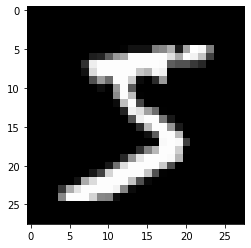

In [3]:
plt.imshow(train_images[0].squeeze(), cmap='gray')

# Generator 生成器

在生成圖片時需要用到 convolution 的變形： transposed convolution（轉置卷積）<br>
一般的卷積可以理解為將圖片的特徵萃取成一張張的 feature map ，
而轉置卷積簡單來說可以理解為將 feature map 還原為圖片（一種 upsampling 的方式）<br>
下圖是 convolution 跟 transposed convolution(deconvolution) 的對應關係：

<img src="https://hackmd.io/_uploads/BkBW2GZlT.jpg" width=700  />

這邊要注意的一點是，在做 Conv2DTranspose 時要注意 feature map 的大小，
而下面將簡述 Conv2DTranspose 的兩個重要的參數所代表的意義：<br>

* stride 步長

<img src="https://hackmd.io/_uploads/rkf7hM-gp.gif" width=300  />

剛好與 Conv2D 相反，在一般卷積中， stride 表示一次走幾格，有就是說當 stride=2 時， feature map size 就會縮小一半，
而 Conv2DTranspose 中的 stride=2 所表示的，則是會將 feature map 中間插入孔洞，因而放大兩倍（當然還要搭配 padding 的設定）。

* padding 填補

<img src="https://hackmd.io/_uploads/Sk8E2zZx6.gif" width=300  />

與 Conv2D 不同，當設定為 'VALID' 時就會像是上圖一樣是有 padding 的，理解的方法可利用 Conv2D 的概念去回推，
當 Conv2D 的 padding='VALID' 時， 4x4 的圖經過 Conv2D(kernel=3) 會產生 2x2 的圖，
那 4x4 就會是 2x2 的圖經過 Conv2DTranspose(kernel=3, padding='VALID') 時所產出的大小。
而在 tf.keras 的程式碼中，當 padding 是 'SAME' 時，會直接放大 stride 的倍數， output size 計算的方式會是如下：

```python
# for `tf.layers.conv2d_transpose()` with `SAME` padding:
out_height = in_height * strides[1]
out_width  = in_width * strides[2]
```
（這邊跟最上面右邊的圖(stride=2, padding='same')有出入的原因是 keras 預設只會將 output 的特徵圖去掉 right/bottom 的 pad（與 padding='valid' 相比），但如果設定超參數 Conv2DTranspose(output_padding=0) 的話，就會將四周都去掉，而輸出跟最上面右邊的圖一樣的 shape）


如果是自行定義的padding的話，則計算公式如下：

```python
# for `tf.layers.conv2d_transpose()` with given padding:
out_height = strides[1] * (in_height - 1) + kernel_size[0] - 2 * padding_height
out_width  = strides[2] * (in_width - 1) + kernel_size[1] - 2 * padding_width
```

如果對於 convolution 的 input size 與 output size 不熟的話，以下是公式，如果要把它轉成 deconvolution 的話，將 input 與 output size 互換就可以得到還原後的結果：<br>

<img src="https://hackmd.io/_uploads/BkYB2z-e6.png" width=300  />

W 代表 convolution 的 input size ； pad 表示單邊的 padding size ； ks 表示 kernel size ； S 表示 stride


如果上面的解釋還是不清楚，下面有兩種對於 transposed convolution 用圖像化的解釋給學員參考：

<img src="https://hackmd.io/_uploads/Bye6K7be6.gif" width=600  />
<br>
<img src="https://hackmd.io/_uploads/HkkAKmWeT.gif" width=600  />

In [4]:
class Generator(Model):
    def __init__(self, z_dim):

        # super 是讓 Generator class 能夠繼承 Model 的 __init__ 中的變數
        super(Generator, self).__init__()

        self.model = Sequential()

        # [z_dim] => [7, 7, 128]
        self.model.add(Dense(7 * 7 * 128, use_bias=False, input_shape=(z_dim,)))

        self.model.add(LeakyReLU())
        self.model.add(Reshape((7, 7, 128)))

        # [7, 7, 128] => [14, 14, 64]
        self.model.add(Conv2DTranspose(64, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [14, 14, 64] => [28, 28, 1]
        self.model.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='tanh'))

    def call(self, x):
        return self.model(x)

# Discriminator 判別器

discriminator 的結構就跟一般 cnn 一模一樣，這邊就不再多加贅述。

In [5]:
class Discriminator(Model):
    def __init__(self):

        # super 是讓 Discriminator class 能夠繼承 Model 的 __init__ 中的變數
        super(Discriminator, self).__init__()

        self.model = Sequential()

        # [28, 28, 1] => [14, 14, 64]
        self.model.add(Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1)))
        self.model.add(LeakyReLU())

        # [14, 14, 64] => [7, 7, 128]
        self.model.add(Conv2D(128, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [7, 7, 128] => [4, 4, 256]
        self.model.add(Conv2D(256, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [4, 4, 256] => [1]
        self.model.add(Flatten())
        self.model.add(Dense(1))

    def call(self, x):
        return self.model(x)

# Loss function 損失函數

GAN 中 generator 與 discriminator 要 optimize 的對象是不同的，所以要寫兩個 loss function 分別作 gradient descend 。<br>

<img src="https://hackmd.io/_uploads/r1qgpGbga.png" width=500  />

上表是 GAN 的演算法， discriminator 的 loss 為「真實資料卻分成假的(d_loss_real)+假資料卻分成真的(d_loss_fake)」，
generator 的 loss 為「產生的假資料被判為假資料(g_loss)」<br>
（這邊的例子中，我們的 generator loss 會改寫成由 Ian Goodfellow 在論文後半部所提出的下面的形式，好處是一開始參數更新得比較快）<br>

<img src="https://hackmd.io/_uploads/SkOJW7Zxp.png" width=300  />


In [6]:
def gan_loss(d_real_logits, d_fake_logits):
    # d_real_logits 為 discriminator 看了真實資料的 output，
    # d_fake_logits 為 discriminator 看了 generator 製造的假資料的 output

    # 定義 cross entropy 作為衡量標準，from_logits 是指要將 input 作 sigmoid 處理
    cross_entropy = BinaryCrossentropy(from_logits=True)
    # discriminator loss
    d_loss_real = cross_entropy(tf.ones_like(d_real_logits), d_real_logits)
    d_loss_fake = cross_entropy(tf.zeros_like(d_fake_logits), d_fake_logits)
    d_loss = d_loss_real + d_loss_fake
    # generator loss
    g_loss = cross_entropy(tf.ones_like(d_fake_logits), d_fake_logits)
    return d_loss, g_loss

# Start training

In [7]:
generator = Generator(z_dim)
discriminator = Discriminator()
g_optimizer = Adam(learning_rate)
d_optimizer = Adam(learning_rate)

# 固定 seed 以利觀察產出的圖片品質
seed = tf.random.normal([num_examples_to_generate, z_dim])

save_dir = './saved_imgs'
checkpoint_dir = './training_checkpoints'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_optimizer=g_optimizer,
                                 d_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [8]:
@tf.function
def train_step(real_images, generator, discriminator, g_optimizer, d_optimizer):

    noise = tf.random.normal([BATCH_SIZE, z_dim])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_images = generator(noise)

        d_real_logits = discriminator(real_images)
        d_fake_logits = discriminator(fake_images)

        d_loss, g_loss = gan_loss(d_real_logits, d_fake_logits)

    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    return d_loss, g_loss

In [9]:
def generate_and_save_images(model, epoch, test_input, save_path):

    predictions = model(test_input)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # 每 5 個 epoches 存一次圖片
    if (epoch + 1) % 5 == 0:
        plt.savefig(os.path.join(save_path, 'image_at_epoch_{:04d}.png'.format(epoch)))

    plt.show()

In [10]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch, generator, discriminator,
                                        g_optimizer, d_optimizer)

        # 產生圖片
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        print('discriminator loss: %.5f' % d_loss)
        print('generator loss: %.5f' % g_loss)
        generate_and_save_images(generator, epoch + 1, seed, save_dir)

        # 每 25 個 epochs 存一次模型
        if (epoch + 1) % 25 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # 在最後一個 epoch 再產生一次圖片與儲存一次權重
    generate_and_save_images(generator, epochs, seed, save_dir)
    checkpoint.save(file_prefix=checkpoint_prefix)

2023-09-23 09:35:02.424890: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Time for epoch 1 is 8.67782711982727 sec
discriminator loss: 0.04168
generator loss: 5.35676


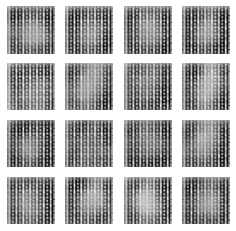

Time for epoch 2 is 6.400126218795776 sec
discriminator loss: 0.04049
generator loss: 5.84395


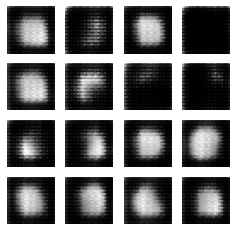

Time for epoch 3 is 6.441199779510498 sec
discriminator loss: 0.01252
generator loss: 9.44017


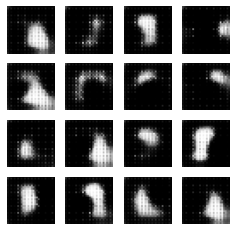

Time for epoch 4 is 6.47198486328125 sec
discriminator loss: 0.04195
generator loss: 8.65101


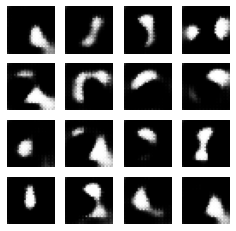

Time for epoch 5 is 6.514395713806152 sec
discriminator loss: 0.08253
generator loss: 5.82973


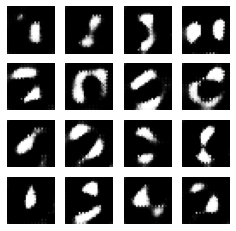

Time for epoch 6 is 6.567140817642212 sec
discriminator loss: 0.07539
generator loss: 6.71243


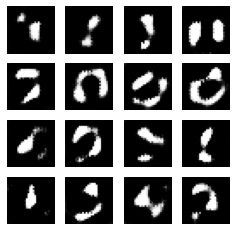

Time for epoch 7 is 6.589626789093018 sec
discriminator loss: 0.13060
generator loss: 5.24814


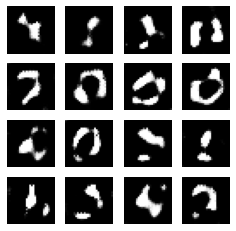

Time for epoch 8 is 6.599220037460327 sec
discriminator loss: 0.10649
generator loss: 5.77907


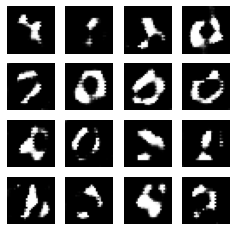

Time for epoch 9 is 6.620173215866089 sec
discriminator loss: 0.16066
generator loss: 5.19737


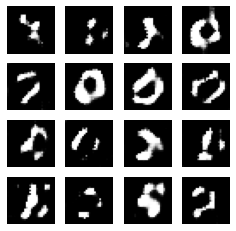

Time for epoch 10 is 6.643987417221069 sec
discriminator loss: 0.06910
generator loss: 5.37796


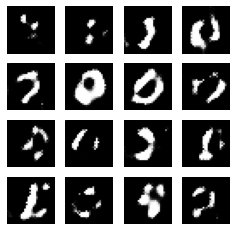

Time for epoch 11 is 6.669895172119141 sec
discriminator loss: 0.08938
generator loss: 5.29056


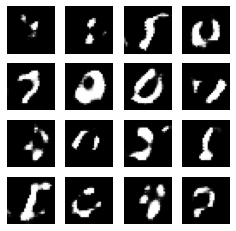

Time for epoch 12 is 6.675865411758423 sec
discriminator loss: 0.12696
generator loss: 4.93958


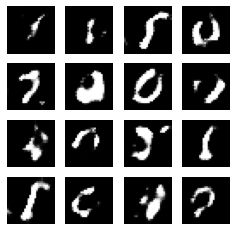

Time for epoch 13 is 6.6972105503082275 sec
discriminator loss: 0.28856
generator loss: 4.51879


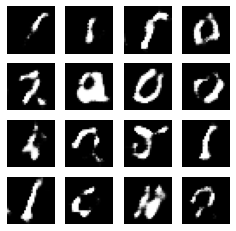

Time for epoch 14 is 6.707490682601929 sec
discriminator loss: 0.37951
generator loss: 3.98710


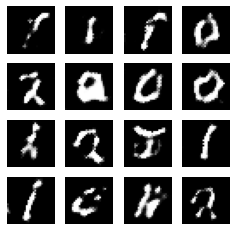

Time for epoch 15 is 6.759183645248413 sec
discriminator loss: 0.22845
generator loss: 3.95941


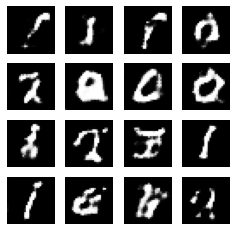

Time for epoch 16 is 6.864084959030151 sec
discriminator loss: 0.21833
generator loss: 3.86958


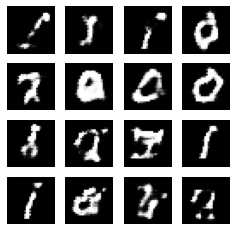

Time for epoch 17 is 6.896812915802002 sec
discriminator loss: 0.23118
generator loss: 4.40582


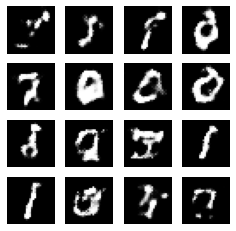

Time for epoch 18 is 6.91777229309082 sec
discriminator loss: 0.17283
generator loss: 4.37749


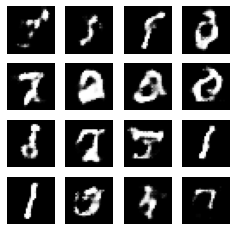

Time for epoch 19 is 6.937069654464722 sec
discriminator loss: 0.34313
generator loss: 3.44132


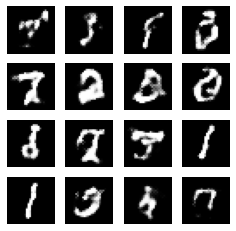

Time for epoch 20 is 6.91313624382019 sec
discriminator loss: 0.29694
generator loss: 2.56526


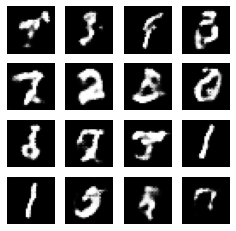

Time for epoch 21 is 6.961749792098999 sec
discriminator loss: 0.37609
generator loss: 2.84080


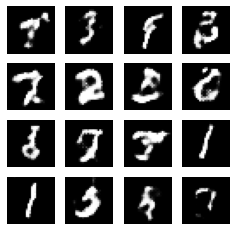

Time for epoch 22 is 7.0101141929626465 sec
discriminator loss: 0.30602
generator loss: 3.55136


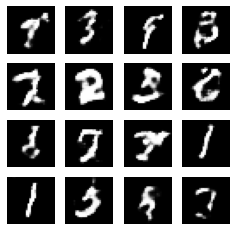

Time for epoch 23 is 6.998233318328857 sec
discriminator loss: 0.31179
generator loss: 3.77198


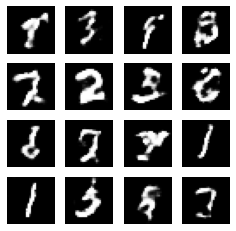

Time for epoch 24 is 7.000706911087036 sec
discriminator loss: 0.32508
generator loss: 3.71253


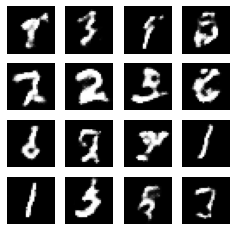

Time for epoch 25 is 6.994846343994141 sec
discriminator loss: 0.44457
generator loss: 2.59755


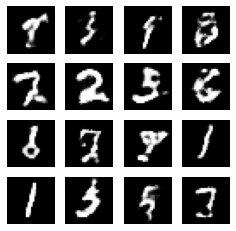

Time for epoch 26 is 6.9116106033325195 sec
discriminator loss: 0.45245
generator loss: 3.97043


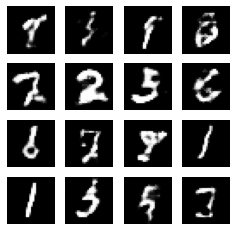

Time for epoch 27 is 6.991497993469238 sec
discriminator loss: 0.39614
generator loss: 2.79746


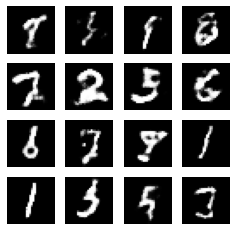

Time for epoch 28 is 7.021789789199829 sec
discriminator loss: 0.36156
generator loss: 3.61018


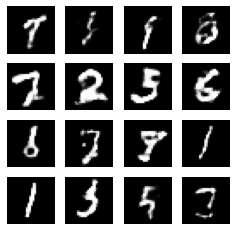

Time for epoch 29 is 7.030436992645264 sec
discriminator loss: 0.56140
generator loss: 3.43384


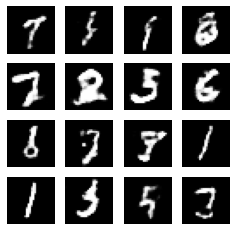

Time for epoch 30 is 7.049560546875 sec
discriminator loss: 0.45848
generator loss: 2.41371


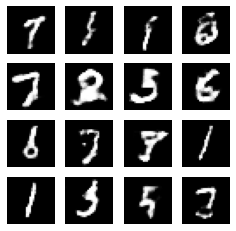

Time for epoch 31 is 7.044459581375122 sec
discriminator loss: 0.34439
generator loss: 2.82592


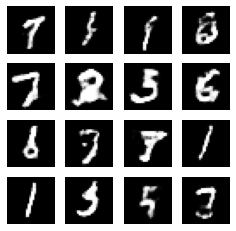

Time for epoch 32 is 7.057781457901001 sec
discriminator loss: 0.47806
generator loss: 2.28031


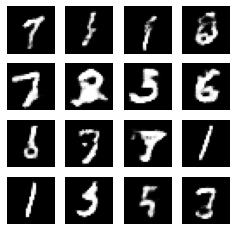

Time for epoch 33 is 7.0476295948028564 sec
discriminator loss: 0.45550
generator loss: 3.28342


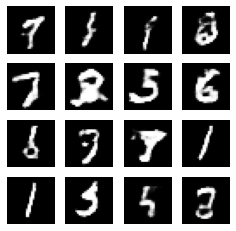

Time for epoch 34 is 7.060787677764893 sec
discriminator loss: 0.64950
generator loss: 2.81478


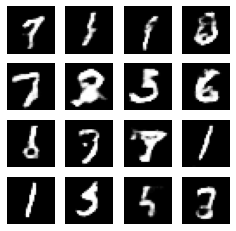

Time for epoch 35 is 7.0321807861328125 sec
discriminator loss: 0.45893
generator loss: 2.82530


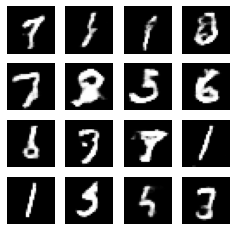

Time for epoch 36 is 7.052315711975098 sec
discriminator loss: 0.52106
generator loss: 3.19680


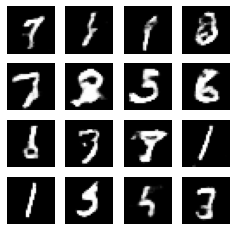

Time for epoch 37 is 7.0764501094818115 sec
discriminator loss: 0.42105
generator loss: 3.42495


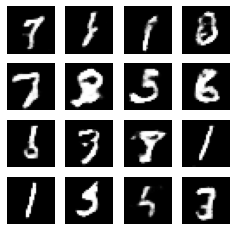

Time for epoch 38 is 7.069304943084717 sec
discriminator loss: 0.62144
generator loss: 3.79682


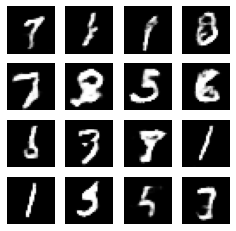

Time for epoch 39 is 7.109730958938599 sec
discriminator loss: 0.40943
generator loss: 3.04703


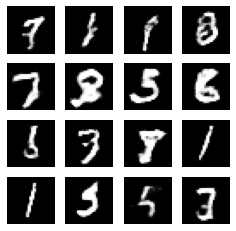

Time for epoch 40 is 7.020801782608032 sec
discriminator loss: 0.52863
generator loss: 3.05438


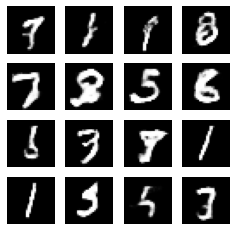

Time for epoch 41 is 7.092636585235596 sec
discriminator loss: 0.43002
generator loss: 3.10206


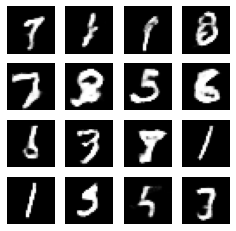

Time for epoch 42 is 7.072608232498169 sec
discriminator loss: 0.55717
generator loss: 3.18157


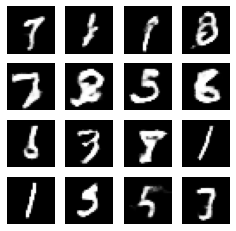

Time for epoch 43 is 7.051607608795166 sec
discriminator loss: 0.55943
generator loss: 3.99800


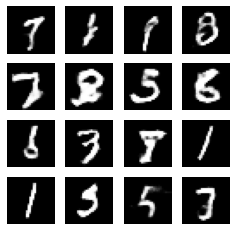

Time for epoch 44 is 7.0729851722717285 sec
discriminator loss: 0.44508
generator loss: 2.53213


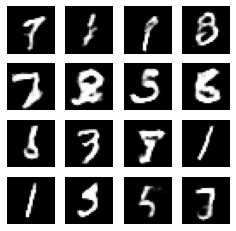

Time for epoch 45 is 7.085137367248535 sec
discriminator loss: 0.51112
generator loss: 3.53274


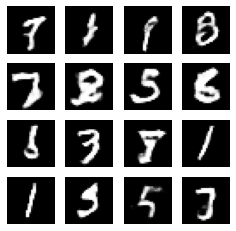

Time for epoch 46 is 7.074992895126343 sec
discriminator loss: 0.48330
generator loss: 3.28029


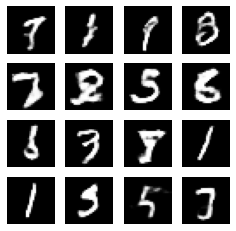

Time for epoch 47 is 7.046982049942017 sec
discriminator loss: 0.42228
generator loss: 2.65156


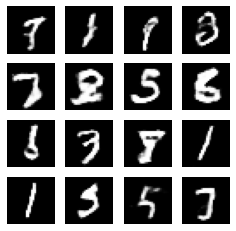

Time for epoch 48 is 7.111734390258789 sec
discriminator loss: 0.36816
generator loss: 2.81751


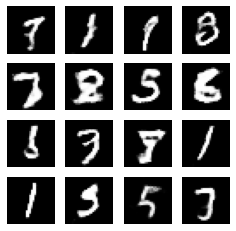

Time for epoch 49 is 7.058969974517822 sec
discriminator loss: 0.65063
generator loss: 3.41912


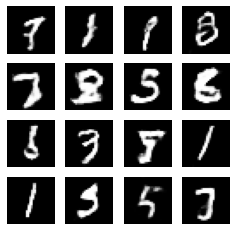

Time for epoch 50 is 7.063063859939575 sec
discriminator loss: 0.46419
generator loss: 2.74140


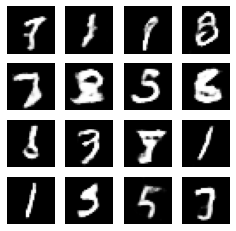

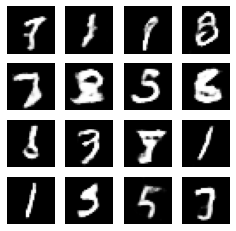

CPU times: user 1min 46s, sys: 9.92 s, total: 1min 56s
Wall time: 6min 11s


In [11]:
%%time
train(train_dataset, EPOCHS)

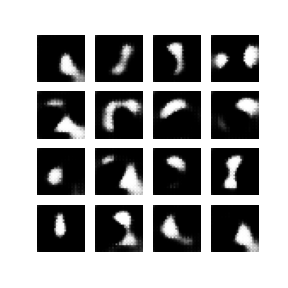

In [12]:
# 使用 imageio 製作 gif 圖
anim_file = 'saved_imgs/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:

    filenames = glob.glob('saved_imgs/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        # skip 掉 部分的 frame
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display(Image(filename=anim_file))

# Mode Collapse 模式崩塌

從上面的訓練結果看來，我們的 Generator 最後好像只會生成很像1或9這種簡單的圖案，像是8、5或是2這些相對複雜的數字圖案是沒有生成出來的。這種問題發生於即便 z vector（雜訊向量/本徵相量）改變了，其對應 generator 的 G(z) 還是不會改變，而這種現象被稱之為 Mode Collapse 。造成這種現象的主要問題是因為 generator 的 loss function 改寫成 "-log D(x)" 的形式所導致，實際的問題用數學來說為 generator 要 minimize 的 loss function 其實是下式：<br>

<img src="https://hackmd.io/_uploads/rkEM-X-lT.png" width=300 />
這個公式有個嚴重的矛盾即是同時要拉近兩個分佈的距離，同時又要推遠兩個分佈，如此會導致梯度不穩定。另一個問題是 KL divergence 懲罰錯誤的不一制性：<br>
<br>

$$ when \; P_g(x)\rightarrow 0 \; and\; P_r(x)\rightarrow 1,\; KL(P_g||P_r) = P_g(x) log\frac{P_g(x)}{P_r(x)} \rightarrow 0$$

$$ when \; P_g(x)\rightarrow 1 \; and\; P_r(x)\rightarrow 0,\; KL(P_g||P_r) = P_g(x) log\frac{P_g(x)}{P_r(x)} \rightarrow +\infty$$

一式為 generator 沒辦法產生真實的資料， KL divergence 對 loss 的影響幾乎沒有；二式為 generator 產生了不真實的資料， KL divergence 對 loss 的影響非常強烈。
由這兩點可以發現，就算 generator 不會產生一些相對複雜的數字也不會有太大的懲罰，但是對於產生一些「實驗性」的數字就會有很大的懲罰，所以 generator 就會產生相對「簡單又安全」的數字來確保 loss 最低。

（對於想了解數學推導又不想看英文論文的人，可以詳見知乎的對於 GAN 的詳細數學說明：https://zhuanlan.zhihu.com/p/25071913 ）

後續有許多對 GAN 的研究也圍繞在 GAN 的 loss function 上面，像是接下來的 WGAN 就是一個例子。

# Generating random digits image

In [13]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

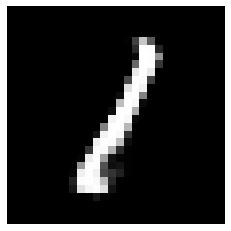

In [14]:
noise = tf.random.normal([1, z_dim])
img = generator(noise, training=False)

# 生成的 pixel 數值介於-1~1之間，故要將其縮放至0~255方能顯示
plt.imshow(img[0,:, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()